# Referances
* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [82]:
import pandas as pd
import numpy as np
from nltk.corpus import reuters
import nltk
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [5]:
# nltk.download('reuters')
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [6]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [7]:
print("Number of training documents:", len(train_documents))
print("Number of testing documents:", len(test_documents))

Number of training documents: 7769
Number of testing documents: 3019


In [8]:
train_categories = [i[0] for i in train_categories]
test_categories = [i[0] for i in test_categories]

In [9]:
trainData = {"content": train_documents}
testData = {"content": test_documents}
trainDf = pd.DataFrame(trainData, columns=["content"])
trainDf['label'] = train_categories
testDf = pd.DataFrame(testData, columns=["content"])
testDf['label'] = test_categories

In [10]:
trainDf.label.value_counts()[0:10]

earn            2843
acq             1650
crude            370
interest         329
money-fx         266
trade            253
grain            218
corn             157
dlr              126
money-supply     125
Name: label, dtype: int64

In [11]:
trainDf = trainDf[trainDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]
testDf = testDf[testDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]

In [12]:
trainDf.shape, testDf.shape

((1561, 2), (584, 2))

# Bidirectional LSTM

In [16]:
# !pip install keras_self_attention

In [85]:
def compute_model_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    labels = np.argmax(labels, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average = 'weighted')
    precision = precision_score(y_true=labels, y_pred=pred , average= 'weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.constraints import maxnorm
from keras.models import model_from_json
# from keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import plot_model
from keras_self_attention import SeqSelfAttention
from keras.models import Sequential
import keras
import tensorflow as tf


In [72]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(trainDf['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15930 unique tokens.


In [73]:
from keras.layers import Layer, InputSpec
from keras import backend as K
from keras import initializers
from keras import regularizers
from keras import constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):


        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)


    def call(self, x):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.softmax(ait)
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [74]:
X = tokenizer.texts_to_sequences(trainDf['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X.shape)

Shape of train data tensor: (1561, 256)


In [75]:
X_test = tokenizer.texts_to_sequences(testDf['content'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

Shape of test data tensor: (584, 256)


In [76]:
Y = pd.get_dummies(trainDf['label']).values
print('Shape of train label tensor:', Y.shape)

Shape of train label tensor: (1561, 6)


In [77]:
Y_test = pd.get_dummies(testDf['label']).values
print('Shape of test label tensor:', Y_test.shape)

Shape of test label tensor: (584, 6)


In [78]:
# X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_val.shape,Y_val.shape)

In [103]:
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedding_layer = Embedding(input_dim=MAX_NB_WORDS+1,
                            output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
#                             embeddings_regularizer=regularizers.l2(0.00),
                            trainable=True)(input_layer)

drop1 = SpatialDropout1D(0.2)(embedding_layer)
lstm_1 = Bidirectional(LSTM(32, name='blstm_1', activation='tanh',return_sequences=True,dropout=0.1), merge_mode='concat')(drop1)
lstm_2 = Bidirectional(LSTM(32, name='blstm_2', activation='tanh',return_sequences=True,dropout=0.1), merge_mode='concat')(lstm_1)
# lstm_1 = BatchNormalization()(lstm_1)
drop2 = Dropout(0.4)(lstm_2)
concat = concatenate([lstm_2,drop2, lstm_1], name='Concatenate')
att_layer = AttentionWithContext()(concat)
drop3 = Dropout(0.5)(att_layer)
predictions = Dense(6, activation='softmax')(drop3)

model = Model(inputs=input_layer, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 100)     5000100     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 256, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 64)      34048       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

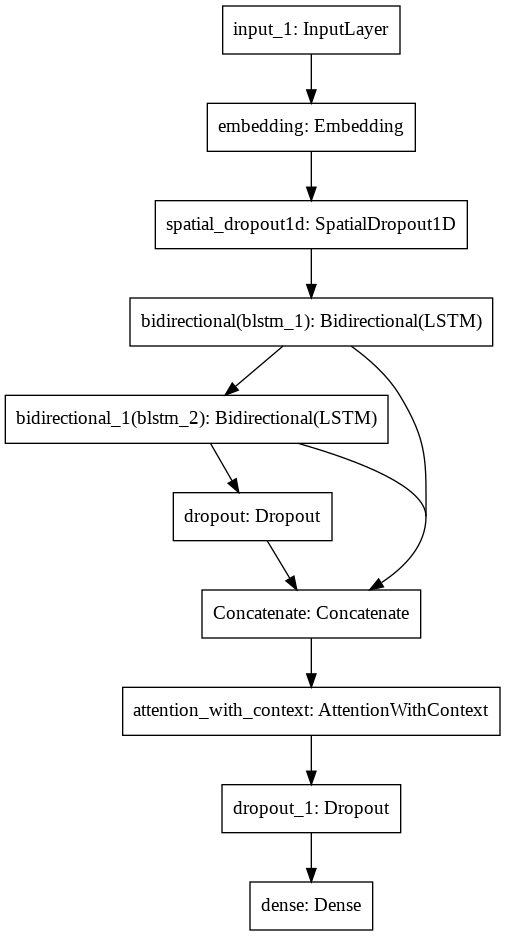

In [104]:
plot_model(model)

In [105]:
keras.backend.clear_session()
sess = tf.compat.v1.Session()
sess.as_default()
monitor_metric = 'val_categorical_accuracy'
STAMP = 'news_BiLSTM_Skip_Atten_256'
early_stopping =EarlyStopping(monitor=monitor_metric,
    patience=5)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path,
    monitor=monitor_metric,
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False)

hist = model.fit(X, Y,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[model_checkpoint,early_stopping])

Epoch 1/100
49/49 [==============================] - 12s 128ms/step - loss: 1.7788 - categorical_accuracy: 0.2144 - val_loss: 1.4857 - val_categorical_accuracy: 0.4709

Epoch 00001: val_categorical_accuracy improved from -inf to 0.47089, saving model to news_BiLSTM_Skip_Atten_256.h5
Epoch 2/100
49/49 [==============================] - 4s 84ms/step - loss: 1.3300 - categorical_accuracy: 0.4856 - val_loss: 0.7485 - val_categorical_accuracy: 0.6216

Epoch 00002: val_categorical_accuracy improved from 0.47089 to 0.62158, saving model to news_BiLSTM_Skip_Atten_256.h5
Epoch 3/100
49/49 [==============================] - 4s 84ms/step - loss: 0.7090 - categorical_accuracy: 0.6426 - val_loss: 0.7512 - val_categorical_accuracy: 0.7123

Epoch 00003: val_categorical_accuracy improved from 0.62158 to 0.71233, saving model to news_BiLSTM_Skip_Atten_256.h5
Epoch 4/100
49/49 [==============================] - 4s 84ms/step - loss: 0.4343 - categorical_accuracy: 0.8441 - val_loss: 0.4998 - val_categoric

In [86]:
y_pred  = model.predict(X_test)

In [88]:
#Test
compute_model_metrics( (y_pred,Y_test))

{'accuracy': 0.809931506849315,
 'f1': 0.8112537101263828,
 'precision': 0.8171640982919913,
 'recall': 0.809931506849315}

In [89]:
y_pred_train  = model.predict(X)
compute_model_metrics( (y_pred_train,Y))

{'accuracy': 0.994234465086483,
 'f1': 0.9942237551452091,
 'precision': 0.9943879852469022,
 'recall': 0.994234465086483}

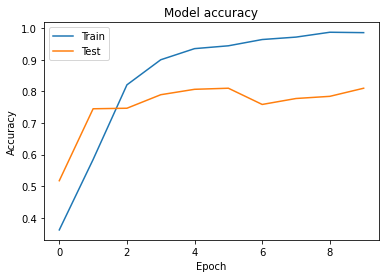

In [83]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

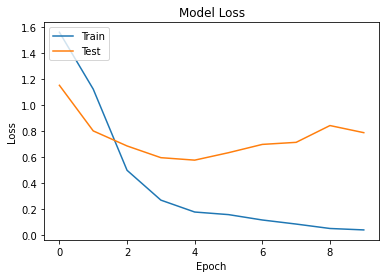

In [84]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()